<a href="https://colab.research.google.com/github/shanikairoshi/QML-and-Deep-Unfolded_QML/blob/main/DUN_VQC_vs_VQC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit-machine-learning
!pip install qiskit qiskit_machine_learning qiskit_algorithms
!pip install qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 6.5 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512543 sha256=f87d9e2517e1af6e1e8865c3faf31689a68bc554aa88ed9d8a1e69f62f515a95
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d51

DUN_VQC

Cost after layer 1: 0.9636964131318582
Cost after layer 2: 0.9738448640618362
Cost after layer 3: 0.9798325710258405
Cost after layer 4: 0.9928041307098789
Cost after layer 5: 0.9668795609735928
Cost after layer 6: 0.9568618678069889
Cost after layer 7: 0.9785935632111148
Cost after layer 8: 0.9516789874512362
Cost after layer 9: 0.9603729399972651
Cost after layer 10: 0.9600914236255615
Cost after layer 11: 0.9561426729126279
Cost after layer 12: 0.9578022531228021
Cost after layer 13: 0.9562192755921151
Cost after layer 14: 0.9419563887314016
Cost after layer 15: 0.9448223226676863
Cost after layer 16: 0.9256490283523731
Cost after layer 17: 0.9232820655993438
Cost after layer 18: 0.9388092002541104
Cost after layer 19: 0.9291450934221019
Cost after layer 20: 0.9235492559003682
Cost after layer 21: 0.9295959894216506
Cost after layer 22: 0.9413669643706177
Cost after layer 23: 0.9288640150630803
Cost after layer 24: 0.9226454020701007
Cost after layer 25: 0.9265962829405734
Cost afte

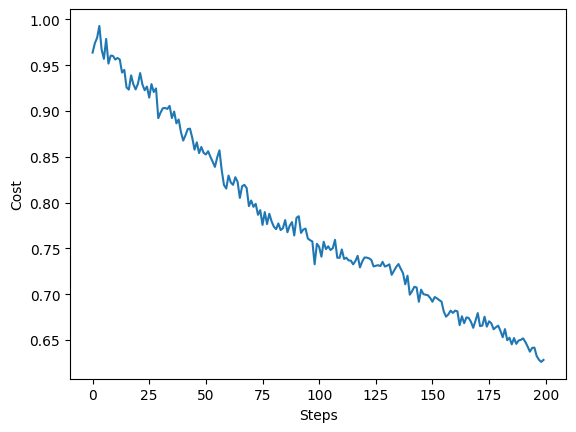

In [10]:
from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 3142

import numpy as np
np.random.seed(algorithm_globals.random_seed)

from qiskit_machine_learning.datasets import ad_hoc_data
# pylint: disable=unbalanced-tuple-unpacking
TRAIN_DATA, TRAIN_LABELS, TEST_DATA, TEST_LABELS = (
    ad_hoc_data(training_size=20,
                test_size=5,
                n=2,
                gap=0.3,
                one_hot=False)
)
# ZZfeatureMap for data encoding a
# Two Local for variational circuit
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
AD_HOC_CIRCUIT.measure_all()
AD_HOC_CIRCUIT.decompose().draw()

#We create a function that associates the data to the feature map and the variational parameters to the variational circuit.
#This is to ensure that the right parameters
#in the circuit are associated with the right quantities.

def circuit_instance(data, variational):
    """Assigns parameter values to `AD_HOC_CIRCUIT`.
    Args:
        data (list): Data values for the feature map
        variational (list): Parameter values for `VAR_FORM`
    Returns:
        QuantumCircuit: `AD_HOC_CIRCUIT` with parameters assigned
    """
    # pylint: disable=invalid-name
    parameters = {}
    for i, p in enumerate(FEATURE_MAP.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(VAR_FORM.ordered_parameters):
        parameters[p] = variational[i]
    return AD_HOC_CIRCUIT.assign_parameters(parameters)

def parity(bitstring):
    """Returns 1 if parity of `bitstring` is even, otherwise 0."""
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight+1) % 2

def label_probability(results):
    """Converts a dict of bitstrings and their counts,
    to parities and their counts"""
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = parity(bitstring)
        probabilities[label] += counts / shots
    return probabilities

from qiskit_aer import Aer
from qiskit import transpile # Import execute from qiskit


def classification_probability(data, variational):
    """Classify data points using given parameters.
    Args:
        data (list): Set of data points to classify
        variational (list): Parameters for `VAR_FORM`
    Returns:
        list[dict]: Probability of circuit classifying
                    each data point as 0 or 1.
    """
    circuits = [circuit_instance(d, variational) for d in data]
    backend = Aer.get_backend('qasm_simulator')
    # Transpile and execute each circuit individually
    results = []
    for circuit in circuits:
        t_circuit = transpile(circuit, backend)
        result = backend.run(t_circuit).result() # Execute each transpiled circuit
        results.append(result)
    classification = [
        label_probability(result.get_counts()) for result in results] # Get counts from each result
    return classification


def cross_entropy_loss(classification, expected):
    """Calculate accuracy of predictions using cross entropy loss.
    Args:
        classification (dict): Dict where keys are possible classes,
                               and values are the probability our
                               circuit chooses that class.
        expected (int): Correct classification of the data point.

    Returns:
        float: Cross entropy loss
    """
    # pylint: disable=invalid-name
    p = classification.get(expected)  # Prob. of correct classification
    return -np.log(p + 1e-10)

def cost_function(data, labels, variational):
    """Evaluates performance of our circuit with `variational`
    parameters on `data`.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): Parameters to use in circuit

    Returns:
        float: Cost (metric of performance)
    """
    # pylint: disable=invalid-name
    classifications = classification_probability(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    return cost

class OptimizerLog:  # pylint: disable=too-few-public-methods
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, stepsize, accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)
    def save_to_csv(self, filename='optimizer_log_dun.csv'):
        """Save evaluations and costs to a CSV file."""
        with open(filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Evaluation', 'Cost'])
            for evaluation, cost in zip(self.evaluations, self.costs):
                writer.writerow([evaluation, cost])
        print(f"Optimizer log saved to {filename}")

# Set up the optimization
from qiskit_algorithms.optimizers import GradientDescent
#from qiskit.algorithms.optimizers import SPSA
log = OptimizerLog()
optimizer = GradientDescent(maxiter=1)

#initial_point = np.random.random(VAR_FORM.num_parameters)
initial_point = np.array([3.28559355, 5.48514978, 5.13099949,
                          0.88372228, 4.08885928, 2.45568528,
                          4.92364593, 5.59032015, 3.66837805,
                          4.84632313, 3.60713748, 2.43546])

def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(TRAIN_DATA, TRAIN_LABELS, variational)

# Run the optimization

# Define a dynamic learning rate function (example: exponential decay)
def dynamic_learning_rate(layer, initial_lr=0.1, decay_rate=0.95):
    return initial_lr * (decay_rate ** layer)

# Deep Unfolding Training
num_layers = 200  # Number of layers (iterations) for deep unfolding
opt_var = initial_point
initial_lr = 0.1  # Initial learning rate

for layer in range(num_layers):
    # Adjust the learning rate for the current layer
    learning_rate = dynamic_learning_rate(layer, initial_lr)

    # Reinitialize optimizer with the current learning rate
    optimizer = GradientDescent(maxiter=1, learning_rate=learning_rate)

    result = optimizer.minimize(objective_function, opt_var)
    opt_var = result.x  # Update parameters for the next layer
    #log.update(layer, opt_var, result.fun)
    log.update(layer, opt_var, result.fun, None, None)

    # Print the cost at each iteration
    print(f"Cost after layer {layer + 1}: {result.fun}")

# Final optimized value and cost
opt_value = log.costs[-1]
opt_var = log.parameters[-1]

#result = optimizer.minimize(objective_function, initial_point)

#opt_var = result.x
#opt_value = result.fun

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

VQC

Iteration 13: Cost = 0.9772606059270373
Iteration 26: Cost = 0.9733547915098353
Iteration 39: Cost = 0.9814252700371879
Iteration 52: Cost = 0.9664318591952034
Iteration 65: Cost = 0.964691212571401
Iteration 78: Cost = 0.9515558038975698
Iteration 91: Cost = 0.9495238360968274
Iteration 104: Cost = 0.9498356941381306
Iteration 117: Cost = 0.9541287386390449
Iteration 130: Cost = 0.9413075019971637
Iteration 143: Cost = 0.9431310500799057
Iteration 156: Cost = 0.9310723779174621
Iteration 169: Cost = 0.9245475746288971
Iteration 182: Cost = 0.9132057204536876
Iteration 195: Cost = 0.9177087546147472
Iteration 208: Cost = 0.9222963870443618
Iteration 221: Cost = 0.9219748855796734
Iteration 234: Cost = 0.9211849452752816
Iteration 247: Cost = 0.916533760937112
Iteration 260: Cost = 0.9038491387202867
Iteration 273: Cost = 0.9074689286537314
Iteration 286: Cost = 0.9065836233912172
Iteration 299: Cost = 0.8990411156549838
Iteration 312: Cost = 0.9166701399966979
Iteration 325: Cost = 0.9

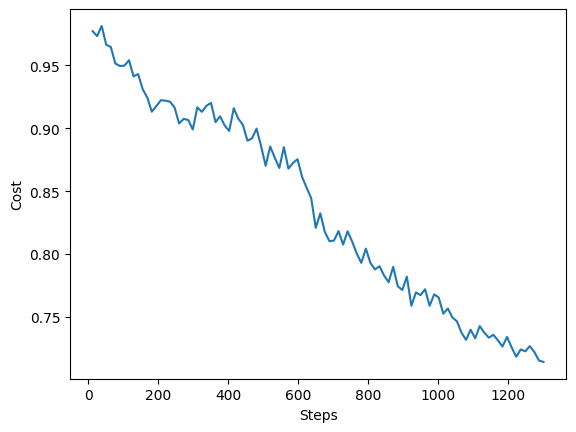

In [15]:
from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 3142

import numpy as np
np.random.seed(algorithm_globals.random_seed)

from qiskit_machine_learning.datasets import ad_hoc_data
# pylint: disable=unbalanced-tuple-unpacking
TRAIN_DATA, TRAIN_LABELS, TEST_DATA, TEST_LABELS = (
    ad_hoc_data(training_size=20,
                test_size=5,
                n=2,
                gap=0.3,
                one_hot=False)
)
# ZZfeatureMap for data encoding a
# Two Local for variational circuit
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
AD_HOC_CIRCUIT.measure_all()
AD_HOC_CIRCUIT.decompose().draw()

#We create a function that associates the data to the feature map and the variational parameters to the variational circuit.
#This is to ensure that the right parameters
#in the circuit are associated with the right quantities.

def circuit_instance(data, variational):
    """Assigns parameter values to `AD_HOC_CIRCUIT`.
    Args:
        data (list): Data values for the feature map
        variational (list): Parameter values for `VAR_FORM`
    Returns:
        QuantumCircuit: `AD_HOC_CIRCUIT` with parameters assigned
    """
    # pylint: disable=invalid-name
    parameters = {}
    for i, p in enumerate(FEATURE_MAP.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(VAR_FORM.ordered_parameters):
        parameters[p] = variational[i]
    return AD_HOC_CIRCUIT.assign_parameters(parameters)

def parity(bitstring):
    """Returns 1 if parity of `bitstring` is even, otherwise 0."""
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight+1) % 2

def label_probability(results):
    """Converts a dict of bitstrings and their counts,
    to parities and their counts"""
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = parity(bitstring)
        probabilities[label] += counts / shots
    return probabilities

from qiskit_aer import Aer
from qiskit import transpile # Import execute from qiskit


def classification_probability(data, variational):
    """Classify data points using given parameters.
    Args:
        data (list): Set of data points to classify
        variational (list): Parameters for `VAR_FORM`
    Returns:
        list[dict]: Probability of circuit classifying
                    each data point as 0 or 1.
    """
    circuits = [circuit_instance(d, variational) for d in data]
    backend = Aer.get_backend('qasm_simulator')
    # Transpile and execute each circuit individually
    results = []
    for circuit in circuits:
        t_circuit = transpile(circuit, backend)
        result = backend.run(t_circuit).result() # Execute each transpiled circuit
        results.append(result)
    classification = [
        label_probability(result.get_counts()) for result in results] # Get counts from each result
    return classification


def cross_entropy_loss(classification, expected):
    """Calculate accuracy of predictions using cross entropy loss.
    Args:
        classification (dict): Dict where keys are possible classes,
                               and values are the probability our
                               circuit chooses that class.
        expected (int): Correct classification of the data point.

    Returns:
        float: Cross entropy loss
    """
    # pylint: disable=invalid-name
    p = classification.get(expected)  # Prob. of correct classification
    return -np.log(p + 1e-10)

def cost_function(data, labels, variational):
    """Evaluates performance of our circuit with `variational`
    parameters on `data`.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): Parameters to use in circuit

    Returns:
        float: Cost (metric of performance)
    """
    # pylint: disable=invalid-name
    classifications = classification_probability(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    return cost

class OptimizerLog:  # pylint: disable=too-few-public-methods
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

        # Print the cost for each iteration
        print(f"Iteration {evaluation}: Cost = {cost}")

    def save_to_csv(self, filename='optimizer_log_default.csv'):
        """Save evaluations and costs to a CSV file."""
        with open(filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Evaluation', 'Cost'])
            for evaluation, cost in zip(self.evaluations, self.costs):
                writer.writerow([evaluation, cost])
        print(f"Optimizer log saved to {filename}")

# Set up the optimization
from qiskit_algorithms.optimizers import GradientDescent
#from qiskit.algorithms.optimizers import SPSA
log = OptimizerLog()
optimizer = GradientDescent(maxiter=100, callback=log.update)

#initial_point = np.random.random(VAR_FORM.num_parameters)
initial_point = np.array([3.28559355, 5.48514978, 5.13099949,
                          0.88372228, 4.08885928, 2.45568528,
                          4.92364593, 5.59032015, 3.66837805,
                          4.84632313, 3.60713748, 2.43546])

def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(TRAIN_DATA, TRAIN_LABELS, variational)

# Run the optimization
result = optimizer.minimize(objective_function, initial_point)

opt_var = result.x
opt_value = result.fun

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

Key Modifications:
Custom Training Loop: The training loop explicitly iterates through num_layers, where each layer represents one step of the optimizer.

Optimizer with Maxiter=1: The optimizer is set to perform only one iteration per call, corresponding to one layer in the deep unfolding process.

Parameter Update per Layer: After each layer, the parameters are updated, and the optimizer’s performance is logged.

1. Update the Optimization Process
Instead of using the standard GradientDescent optimizer for a fixed number of iterations, we will define a custom training loop that corresponds to layers in the deep unfolding process.
2. Layer-wise Training
Each layer in the deep unfolding will correspond to a single step of the optimizer. After each layer, you will update the parameters of the quantum circuit.
3. Controlled Layer Count
We will explicitly control the number of layers (iterations) in the deep unfolding process.

The deep unfolding approach differs from the normal process of training a Variational Quantum Classifier (VQC) in several key ways:

1. Optimization Approach
Normal Process: In the standard VQC training, you typically use a classical optimizer (like gradient descent, SPSA, or COBYLA) that iteratively adjusts the parameters of the quantum circuit to minimize a loss function. This process continues until the optimizer converges to a solution or until a predefined number of iterations is reached.
Deep Unfolding: Instead of running an optimizer to convergence, deep unfolding transforms the iterative optimization process into a sequence of layers. Each layer represents a single iteration of the optimization algorithm, and you explicitly design the process to unfold over a fixed number of layers. The parameters are updated layer by layer, mimicking the steps of the optimization algorithm.
2. Training Dynamics
Normal Process: The optimizer dynamically adjusts the parameters based on the gradient (or some other update rule) in each iteration, potentially requiring many iterations to find a good solution. The focus is on finding a global or local minimum by iterating until convergence.
Deep Unfolding: The training is constrained to a fixed number of layers, each corresponding to an iteration of the optimization algorithm. This approach can potentially provide faster convergence and more structured training dynamics by explicitly controlling the number of updates, effectively limiting the optimization process.
3. Parameter Updates
Normal Process: Parameter updates occur continuously across the entire optimization process, with the algorithm iterating until a stopping criterion is met (e.g., convergence tolerance, maximum iterations).
Deep Unfolding: Parameters are updated in a discrete, layer-wise manner, with the number of updates directly tied to the number of layers. This can lead to a more structured and potentially more interpretable model, as each layer corresponds to a specific iteration of the underlying optimization process.
4. Model Structure
Normal Process: The model structure is primarily defined by the quantum circuit (the ansatz), and the optimization process is treated as an external method to find the best parameters for this structure.
Deep Unfolding: The model structure is explicitly tied to the optimization process, where the number of layers in the model corresponds directly to the number of iterations in the optimization algorithm. This creates a more integrated model where the architecture and training process are closely intertwined.
5. Flexibility and Interpretability
Normal Process: The optimization process is generally flexible, with the ability to use various optimizers and dynamically adjust learning rates or other hyperparameters. However, the process may be less interpretable since the training dynamics are not explicitly modeled.
Deep Unfolding: The process is more structured and potentially more interpretable, as each layer corresponds to a known step in an optimization algorithm. This structure can lead to better insights into how the model is learning, although it may reduce flexibility compared to the normal process.
6. Training Efficiency
Normal Process: Training efficiency depends on the choice of optimizer and the complexity of the quantum circuit. Some optimizers might require many iterations to converge, leading to longer training times.
Deep Unfolding: By fixing the number of layers and tying each layer to a specific iteration, deep unfolding can potentially improve training efficiency, as it imposes a structured limit on the number of updates. This can lead to faster training, especially in scenarios where a full iterative optimization might be overkill.
7. Application of Regularization
Normal Process: Regularization methods can be applied in a post-hoc manner, adjusting the loss function or the parameters during the optimization process to prevent overfitting.
Deep Unfolding: Regularization can be built into the deep unfolding process, where specific layers or steps in the unfolding can be designed to introduce regularization effects. This can lead to a more integrated and potentially more effective regularization strategy.
Summary
In essence, the deep unfolding approach imposes a fixed structure on the optimization process, transforming it from a potentially lengthy iterative procedure into a structured, layer-wise training process. This can lead to improvements in training efficiency, interpretability, and potentially even performance, depending on the specific application and problem at hand. However, it also requires careful design and might reduce flexibility compared to the standard approach.